In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from PIL import Image

In [2]:
# データセットディレクトリ
directory = '/Volumes/SSD/img_align_celeba'
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.jpg')]

print(f'ファイル数: {len(image_files)}')

ファイル数: 405198


In [24]:
# 画像の前処理関数

def load_and_preprocess_image(file_path):
    image = Image.open(file_path)
    image = image.resize((64, 64))  # 必要に応じてリサイズ
    image_array = np.array(image) / 255.0  # 正規化
    image_array = image_array.astype(np.float32)
    return image_array

def load_and_preprocess_from_path_label(file_path):
    image = tf.numpy_function(load_and_preprocess_image, [file_path], tf.float32)
    image.set_shape((64, 64, 3))  # 明示的に形状を設定
    return image

In [25]:
# ファイルパスのデータセットを作成
path_ds = tf.data.Dataset.from_tensor_slices(image_files)

# 画像の前処理を適用
image_ds = path_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# データセットのバッチサイズを設定
batch_size = 32
dataset = image_ds.batch(batch_size)

# データセットのキャッシングとプリフェッチ
dataset = dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# データセットの形式を確認
for batch in dataset.take(1):
    print(batch.shape)


(32, 64, 64, 3)


2024-08-19 12:19:44.968791: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
# データセットをシャッフルし、トレーニングとテストに分割
dataset = dataset.shuffle(buffer_size=len(image_files))
train_size = int(0.8 * len(image_files))  # 80%をトレーニングデータに
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print(f'トレーニングデータのバッチ数: {len(train_dataset)}')
print(f'テストデータのバッチ数: {len(test_dataset)}')

トレーニングデータのバッチ数: 12663
テストデータのバッチ数: 0


In [27]:
# VAEのモデル定義
latent_dim = 2  # 潜在空間の次元数

In [28]:
def build_vae(latent_dim):
    # エンコーダー
    encoder_inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # デコーダー
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = models.Model(encoder_inputs, vae_outputs, name="vae")

    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)

In [29]:
# カスタムロス関数の定義
def vae_loss(x, vae_outputs):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, vae_outputs))
    reconstruction_loss *= 64 * 64 * 3
    z_mean, z_log_var, z = encoder(x)
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    return reconstruction_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [30]:
# モデルの訓練
epochs = 10
vae.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10


ValueError: None values not supported.

ファイル数: 405198
Batch shape: (32, 64, 64, 3)


2024-08-19 12:28:05.727884: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


トレーニングデータのバッチ数: 12663
テストデータのバッチ数: 0
Epoch 1/10
An error occurred during training: None values not supported.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━

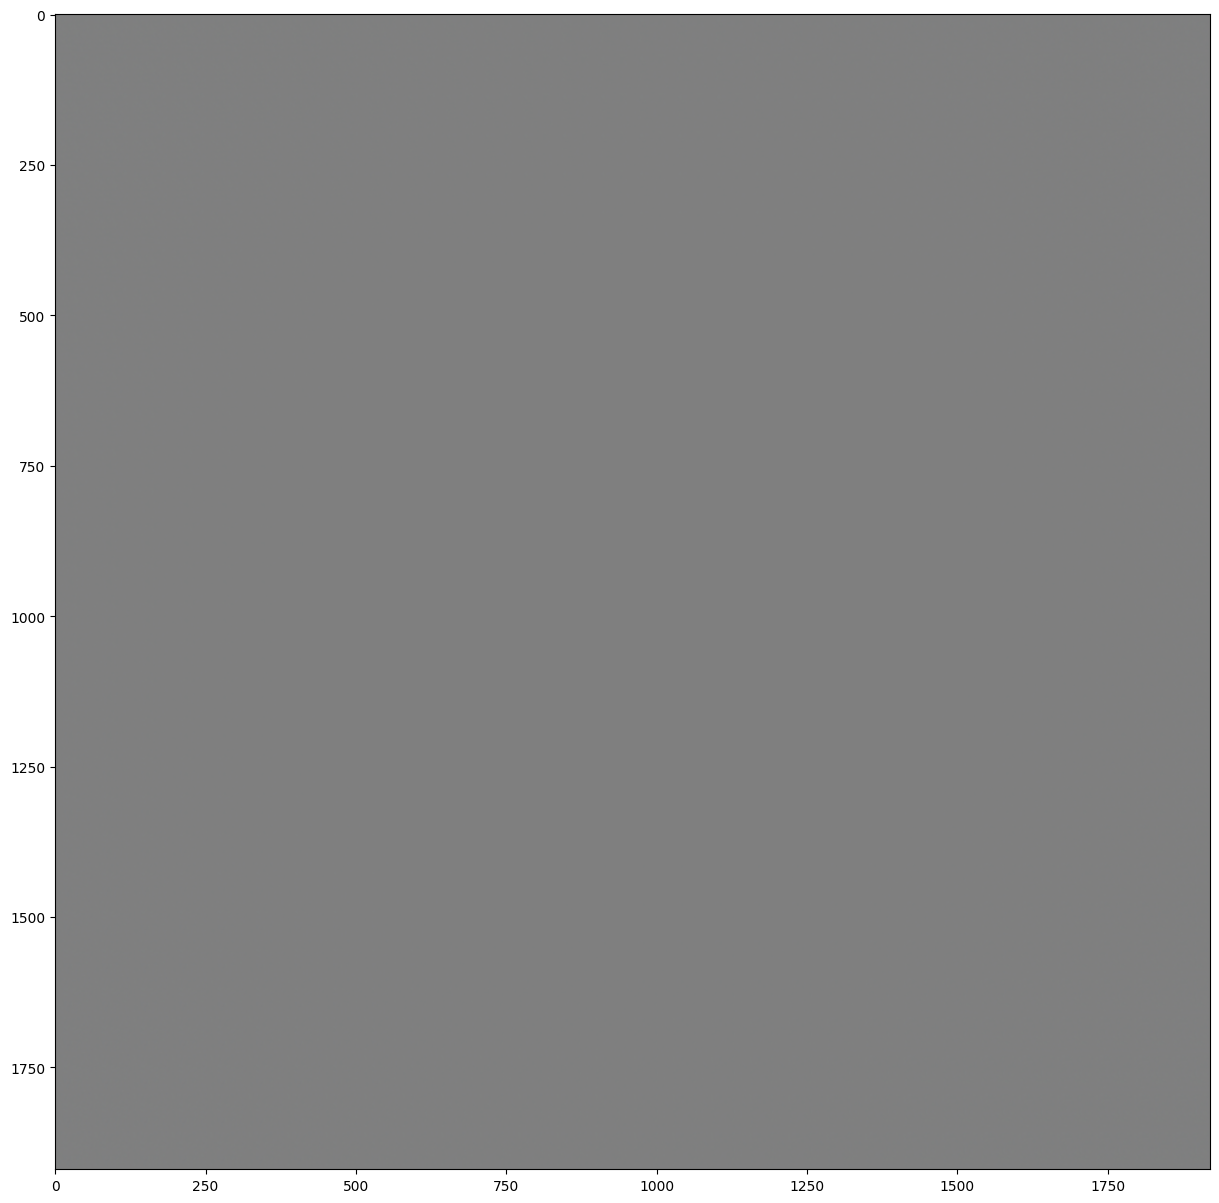

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from PIL import Image

# データセットディレクトリ
directory = '/Volumes/SSD/img_align_celeba'
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.jpg')]

print(f'ファイル数: {len(image_files)}')

# 画像の前処理関数
def load_and_preprocess_image(file_path):
    image = Image.open(file_path)
    image = image.resize((64, 64))  # 必要に応じてリサイズ
    image_array = np.array(image) / 255.0  # 正規化
    image_array = image_array.astype(np.float32)
    return image_array

def load_and_preprocess_from_path_label(file_path):
    image = tf.numpy_function(load_and_preprocess_image, [file_path], tf.float32)
    image.set_shape((64, 64, 3))  # 明示的に形状を設定
    return image

# ファイルパスのデータセットを作成
path_ds = tf.data.Dataset.from_tensor_slices(image_files)

# 画像の前処理を適用
image_ds = path_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.AUTOTUNE)

# データセットのバッチサイズを設定
batch_size = 32
dataset = image_ds.batch(batch_size)

# データセットのキャッシングとプリフェッチ
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# データセットの確認
for batch in dataset.take(1):
    print("Batch shape:", batch.shape)

# データセットをシャッフルし、トレーニングとテストに分割
dataset = dataset.shuffle(buffer_size=len(image_files))
train_size = int(0.8 * len(image_files))  # 80%をトレーニングデータに
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print(f'トレーニングデータのバッチ数: {len(train_dataset)}')
print(f'テストデータのバッチ数: {len(test_dataset)}')

# VAEのモデル定義
latent_dim = 2  # 潜在空間の次元数

def build_vae(latent_dim):
    # エンコーダー
    encoder_inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    # デコーダー
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = models.Model(encoder_inputs, vae_outputs, name="vae")

    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)

# カスタムロス関数の定義
def vae_loss(x, vae_outputs):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, vae_outputs))
    reconstruction_loss *= 64 * 64 * 3
    z_mean, z_log_var, z = encoder(x)
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    return reconstruction_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

# モデルの訓練
epochs = 10
try:
    vae.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
except Exception as e:
    print("An error occurred during training:", e)

# 潜在空間の可視化
def plot_latent_space(encoder, decoder, n=30, figsize=15):
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure)
    plt.show()

plot_latent_space(encoder, decoder)


In [ ]:
# 潜在空間の可視化
def plot_latent_space(encoder, n=30, figsize=15):
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure)
    plt.show()

plot_latent_space(encoder)